In [1]:
from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 
from scipy.special import shichi
from mpmath import meijerg
import scipy
import matplotlib.pyplot as plt
import qutip
from qutip import ptrace 
import numpy as np 
import time 




# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import qutip.solver.brmesolve as brmesolve  
import scipy.special

In [2]:
"""Define Constants"""
#hbar, kb=1



we=1 # With hbar = 1 this is the upper energy
wg=0# ground state
ve=0.1 #  ground state frequencie from the exited atomic state in 0.1*we 
vg=0.1 # ground state frequencie from the ground atomic state 
λ1=2# dim less coupling constant depending on the shift of the energy minima shifts in space
g=0.5 #couplig cavity to sysem 

tlist = np.linspace(0,60, 1000) # 40 times atomic frequencie 4 times vibronic
#### ground parameters
λ2=(vg**2-ve**2)/(4*vg**2) # dim less coupling constant depending on the vibronic freq 
w0=we- wg + λ1**2 *vg**3 /ve**2
w00 = we - wg + (ve - vg )/2


beta=5 #temp Einheit von  hb*omega durch kb
A=-λ1/(1+4*λ2)
#A=-λ1*(vg**2/ve**2)

#rs=2*(2*np.pi*1J+np.log(1+4*λ2)**0.25)
rs=1/4*(np.log(ve**2/vg**2))

def nb(w):
    return np.float128(1/(np.exp((w) * beta)-1))
N=8# size of the vibronic hilbi space 
N_photons=8
#tlist=np.linspace[0,1,10]
# operators
b  = qutip.tensor(qutip.qeye(2),qutip.destroy(N),qutip.qeye(N_photons)) #ladder operator of the vibronic modes 
a  = qutip.tensor(qutip.qeye(2),qutip.qeye(N),qutip.destroy(N_photons)) #ladder operator of the photonic modes 
P12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_photons))
P21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_photons))
P11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N),qutip.qeye(N_photons))
P22 = qutip.tensor(basis(2,1)*basis(2,1).dag(),qutip.qeye(N),qutip.qeye(N_photons))
#psi0 = qutip.tensor(basis(2,1),basis(N,0))   #|e,0>
rho0=qutip.tensor(basis(2,1)*basis(2,1).dag(),basis(N,0)*basis(N,0).dag(),basis(N_photons,0)*basis(N_photons,0).dag()) #|e,0><e,0|
H_cav=((we-wg)*λ1*vg)*a.dag()*a +g*(P21*a+P12*a.dag())
#System hamiltonian
H= vg*b.dag()*b +w0*P21*P12 + λ1*vg*(b+b.dag())*P21*P12  + λ2*vg*(b+b.dag())**2  *P21*P12  +H_cav  

H_diag=vg*P12*P21*b.dag()*b+ (vg*b.dag()*b+w00)*P21*P12
 
O1=P12+P21
O2=b+b.dag()
wc = 10.0      # Cutoff-Frequenz ω_c
g = 0.1        # Kopplungskonstante

# Berechnung der Lamb-Shift-Funktion
def gamma(wx, wc, g):
    term1 = scipy.special.gammainc(0, -wx / wc)  # Gamma[0, -w0/wc]
    term2 = -np.log(-wx)
    term3 = np.log(-wx / wc)
    term4 = np.log(wc)
    
    prefactor = g / (np.pi * wc)
    bracket = (wc + wx * np.exp(w0 / wc)) * (term1 + term2 + term3 + term4)
    
    return float(prefactor * bracket.real())

print(scipy.special.gammainc(0,1))
evals , ekets = H.eigenstates()
evals2 , ekets2 = H_diag.eigenstates()
print(H_diag)
#print(ekets,ekets2)
state1=qutip.tensor( basis(2,1),qutip.basis(N,0))
state2=qutip.tensor(basis(2,0),qutip.basis(N,1))
#print(state1.dag()*H_diag*state2)
def SS(H):
    return (-H*beta).expm()/((-H*beta).expm().tr())
print((SS(H)*P22).tr())
print((SS(H_diag)*P22).tr())
"""wc = 10.0      # Cutoff-Frequenz ω_c
g = 0.1        # Kopplungskonstante

# Berechnung der Lamb-Shift-Funktion
def lamb_shift(w0, wc, g):
    term1 = gammainc(0, -w0 / wc, regularized=False)  # Gamma[0, -w0/wc]
    term2 = -log(-w0)
    term3 = log(-w0 / wc)
    term4 = log(wc)
    
    prefactor = g / (pi * wc)
    bracket = (wc + w0 * exp(w0 / wc)) * (term1 + term2 + term3 + term4)
    
    return float(prefactor * bracket)"""


1.0
Quantum object: dims=[[2, 8, 8], [2, 8, 8]], shape=(128, 128), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.7 0.  0. ]
 [0.  0.  0.  ... 0.  1.7 0. ]
 [0.  0.  0.  ... 0.  0.  1.7]]
(0.17021357420737673+0j)
0.006692850924284868


'wc = 10.0      # Cutoff-Frequenz ω_c\ng = 0.1        # Kopplungskonstante\n\n# Berechnung der Lamb-Shift-Funktion\ndef lamb_shift(w0, wc, g):\n    term1 = gammainc(0, -w0 / wc, regularized=False)  # Gamma[0, -w0/wc]\n    term2 = -log(-w0)\n    term3 = log(-w0 / wc)\n    term4 = log(wc)\n    \n    prefactor = g / (pi * wc)\n    bracket = (wc + w0 * exp(w0 / wc)) * (term1 + term2 + term3 + term4)\n    \n    return float(prefactor * bracket)'

In [3]:

D_opt=(A*(b.dag()-b)).expm()
S_opt=(1/2*rs*(b*b-b.dag()*b.dag())).expm() #seldmade
U = P12*P21 +(D_opt * S_opt*P21*P12)
# Transformation auf sigma
#print(P12*P21 +D_opt *P21*P12,(P12*P21 +D_opt *P21*P12).dag()*b*(P12*P21 +D_opt *P21*P12))
#print(D_op,D_opt)
P12rt = U.dag() * P12 * U

#print(P12rt,P12r,D_op*S_op*P12)
#U1 = P12*P21 +D_op *P21*P12
#U2 = P12*P21 +S_op *P21*P12

#U=U1*U2

brt=U.dag() *b * U# selfmade disp

br2= b* P12*P21  +(b *np.cosh(rs)  - b.dag()*np.sinh(rs)+A*np.cosh(rs))*P21*P12
be = (np.cosh( rs) *b + np.sinh( rs)* b.dag() + A* np.exp(rs) )*P21*P12

#print(b+A*P22,((P11+D_opt*P22).dag())*b*(P11+D_opt*P22),br3)
#print(U.dag() *H *U)
#c=b* P12*P21  +(b *np.cosh(rs)  - b*np.sinh(rs))*P21*P12
c=b* P12*P21  +(b *np.cosh(rs)  - b*np.sinh(rs))*P21*P12
P12r=P12rt
P21r=P12rt.dag()
#rho0r=Ut.dag()*rho0*Ut #
#rho0r=U.dag()* rho0 *U #neue  BAsis
H_ls=c.dag()*c+P21r*P12r+A*np.cosh(rs)*(P22+P11)*(A*np.cosh(rs)*(P22+P11)).dag()
H_cav_diag= ((we-wg)*λ1*vg)*a.dag()*a +g*(P21r*a+P12r*a.dag())



/home/sander/anaconda3/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/home/sander/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


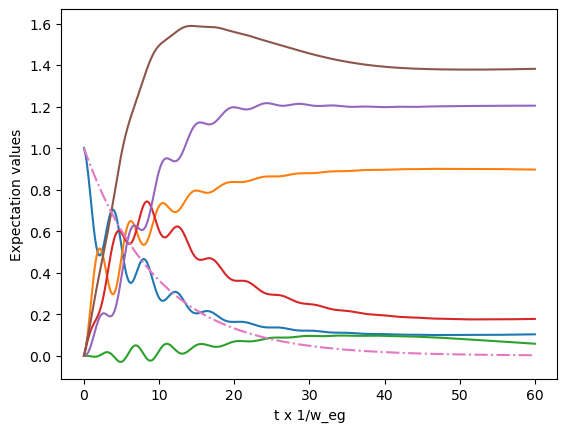

In [4]:
opts = Options(store_states = True)

########################################################################################################
gamma_1=0.1
gamma_2=0.1
c_op_list=[]

c_op_list.append(np.sqrt((nb(w0)+1)*gamma_1)*P12)
c_op_list.append(np.sqrt((nb(w0))*gamma_1)*P21)
c_op_list.append(np.sqrt((nb(vg)+1)*gamma_2)*b*P11)
c_op_list.append(np.sqrt((nb(vg))*gamma_2)*b.dag()*P11)
c_op_list.append(np.sqrt((nb(ve)+1)*gamma_2)*b*P22)
c_op_list.append(np.sqrt((nb(ve))*gamma_2)*b.dag()*P22)
Resul_Lindblad=qutip.mesolve(H, rho0, tlist, [c_op_list], [P22, P11,P12,b.dag()*b*P22,b.dag()*b*P11,b.dag()*b*P22+b.dag()*b*P11],options=opts)

fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad.expect[0])
ax.plot(tlist, Resul_Lindblad.expect[1])
ax.plot(tlist, Resul_Lindblad.expect[2])
ax.plot(tlist, Resul_Lindblad.expect[3])
ax.plot(tlist, Resul_Lindblad.expect[4])
ax.plot(tlist, Resul_Lindblad.expect[5])
P1 = np.exp(-beta * w0 / 2) / (np.exp(-beta * w0 / 2) + np.exp(beta * w0 / 2))
ax.plot(tlist,np.exp(-gamma_1 *(2*nb(w00)+1)*tlist)+P1*(1-np.exp(-gamma_1 *(2*nb(w00))*tlist)),linestyle='dashdot') 
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
#ax.legend(("Pe", "Pg","P12","N * P22 ","N * P11","N*P22+N*P11"))
#ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
#ax.axhline(y=(np.abs((SS(H)*(b.dag()*b*(P22+P11))).tr())), xmin=0, xmax=40, color='g', linestyle='--')
#ax.axhline(y=1/(np.exp(beta*vg)-1), xmin=0, xmax=40, color='b', linestyle='--')
plt.show()
from qutip import plot_wigner, coherent
x=Resul_Lindblad.final_state

0.8998392178641434


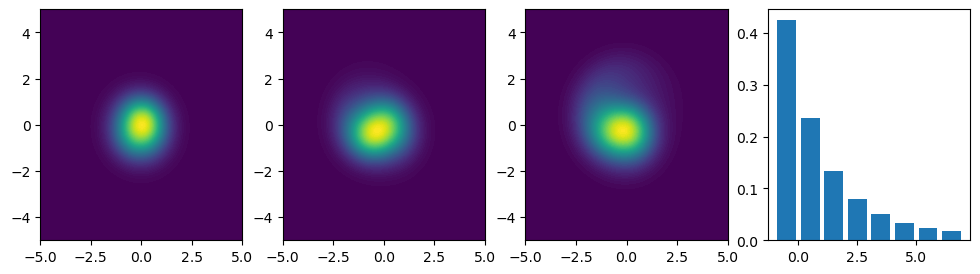

In [5]:
xvec = np.linspace(-5,5,200)
rho_t=Resul_Lindblad.states
rho20=rho_t[200]
rho50=rho_t[500]
rho80=rho_t[800]
print(Resul_Lindblad.expect[1][800])
rho20.ptrace(2)
Wigner1=qutip.wigner(rho20.ptrace(2),xvec,xvec)  
Wigner2=qutip.wigner(rho50.ptrace(2),xvec,xvec)  
Wigner3=qutip.wigner(rho80.ptrace(2),xvec,xvec)  
fig, axes = plt.subplots(1, 4, figsize=(12,3))

cont0 = axes[0].contourf(xvec, xvec, Wigner1, 100)

lbl0 = axes[0].set_title("")

cont1 = axes[1].contourf(xvec, xvec, Wigner2, 100)
lbl1 = axes[1].set_title("")

cont0 = axes[2].contourf(xvec, xvec, Wigner3, 100)

lbl2 = axes[2].set_title("")
bar2 = axes[3].bar(np.arange(0, N)-.5, rho80.ptrace(1).diag())
plt.show()

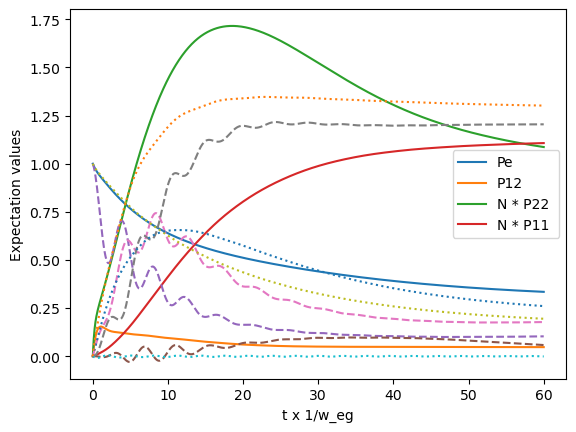

Quantum object: dims=[[2, 8, 8], [2, 8, 8]], shape=(128, 128), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] Quantum object: dims=[[2, 8, 8], [2, 8, 8]], shape=(128, 128), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] Quantum object: dims=[[2, 8, 8], [2, 8, 8]], shape=(128, 128), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
gamma_1_diag=0.1
gamma_2_diag=0.1
c_op_list_diag=[]

c_op_list_diag.append(np.sqrt((nb(w00)+1)*gamma_1_diag)*P12r)
c_op_list_diag.append(np.sqrt((nb(w00))*gamma_1_diag)*P21r)
c_op_list_diag.append(np.sqrt((nb(vg)+1)*gamma_2_diag)*c*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(vg))*gamma_2_diag)*c.dag()*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(ve)+1)*gamma_2_diag)*c*P21r*P12r)
c_op_list_diag.append(np.sqrt((nb(ve))*gamma_2_diag)*c.dag()*P21r*P12r)


c_op_list_diag.append(np.sqrt((nb(w00)+1)*gamma_2_diag)*A *np.cosh(rs)*(P21*P12+P12*P21))
c_op_list_diag.append(np.sqrt((nb(w00))*gamma_2_diag)*A *np.cosh(rs)*(P21*P12+P12*P21))
#cross coreleation thermes slow
Lk_min = qutip.spre(c) * qutip.spost(P12r.dag()) - 0.5 * qutip.spre(P12r.dag() * c) - 0.5 * qutip.spost(P12r.dag() * c)
Lk_min2 = qutip.spre(c.dag()) * qutip.spost(P12r) - 0.5 * qutip.spre(P12r * c.dag()) - 0.5 * qutip.spost(P12r * c.dag())
Lk_plu = qutip.spre(P12r.dag()) * qutip.spost(c) - 0.5 * qutip.spre(c*P12r.dag() ) - 0.5 * qutip.spost(c*P12r )

Resul_Lindblad_diag=qutip.mesolve(H_diag, U.dag()*rho0*U, tlist, [c_op_list_diag], [P21r*P12r, P12r*P21r,P12r,U.dag()*b.dag()*b*U*P21r*P12r,U.dag()*b.dag()*b*U*P12r*P21r])
Resul_Lindblad_diag_cross=qutip.mesolve(H_diag+H_ls, rho0, tlist, [c_op_list_diag,gamma_1*(nb(w00+vg)+1)*(Lk_min+Lk_min2)+gamma_1*(nb(w00+vg))*(Lk_plu+Lk_plu.dag())], [P21*P12, P12*P21,P12,b.dag()*b*P21*P12,b.dag()*b*P12*P21])

fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad_diag.expect[0])
ax.plot(tlist, Resul_Lindblad_diag.expect[2])
ax.plot(tlist, Resul_Lindblad_diag.expect[3])
ax.plot(tlist, Resul_Lindblad_diag.expect[4])

ax.plot(tlist, Resul_Lindblad.expect[0],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[2],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[3],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[4],linestyle="--")

ax.plot(tlist, Resul_Lindblad_diag_cross.expect[0],linestyle=":")
ax.plot(tlist, Resul_Lindblad_diag_cross.expect[2],linestyle=":")
ax.plot(tlist, Resul_Lindblad_diag_cross.expect[3],linestyle=":")
ax.plot(tlist, Resul_Lindblad_diag_cross.expect[4],linestyle=":")
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
ax.legend(("Pe","P12","N * P22 ","N * P11"))
#ax.axhline(y=(np.abs((SS(H_diag)*(b.dag()*b*(P22+P11))).tr())), xmin=0, xmax=40, color='g', linestyle='--')
#ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
#ax.axhline(y=1/(np.exp(beta*vg)-1), xmin=0, xmax=40, color='b', linestyle='--')
plt.show()
print(P12r*P21r,P12*P21,P21*P12+P12*P21)